# Indirect methods for optimal control (The Maximum Principle)
This notebook serves as a quick introduction/review of indirect methods of optimal control. Indirect optimal control is an approach for which one can solve optimal control problems by *restating* the optimal control problem into sub-problems. These sub-problems are often easier to solve numerically, computationally faster, and can deal with nonlinearities. 


## Continuous dynamical systems with inputs
Let's first consider a general continuous time dynamical system with input of the form 
$$ \dot{x}(t) = f(x(t),u(t))$$
where $x(t) \in \mathbb{R}^n$ is the state of the dynamical system at time $t$, $u(t) \in \mathbb{R}^m$ is the control input to the dynamical system at time $t$, and $f(x, u): \mathbb{R}^{n \times m} \to \mathbb{R}^n$ is the (often nonlinear) mapping that takes the state and control and returns the instantaneous change of the state $\dot{x}\in \mathbb{R}^n$. Often, these types of dynamical systems (e.g., robots) are written using the integral form:
$$
    x(t_t) = x(t_0) + \int_{t_0}^{t_f} f(x(t), u(t) ) dt 
$$
where the integration starts at some initial condition $x(t_0)$ at time $t_0$ and integrates forward onto time $t_f$. 
Note that this formulation assumes that $u$ and $x$ are both continuous in $t$ (same goes for $f(x,u)$, but not always true). The integration can be done using any choice of integration method (RK4, Euler, etc.).

We are going to use the following nonlinear dynamical system:
$$
    \dot{x} = f(x, u) = \begin{bmatrix} -0.1 && -1.0 \\ 1.0 && -0.1 \end{bmatrix} \begin{bmatrix}  x_1^3 \\ x_2\end{bmatrix} + \begin{bmatrix} 1.0 && 0. \\ 0. && 1.0 \end{bmatrix} u
$$
where $x = \left[x_1, x_2 \right]^\top$ for our example.

In order to build this model we are going to use an autograd library (Google's Jax autodiff lib). To import we do the following:

In [1]:
import jax.numpy as np
from jax import grad, jit, vmap, jacfwd
from jax.numpy import cos, sin, tan, tanh
from jax.ops import index, index_add, index_update

# %matplotlib notebook
import matplotlib.pyplot as plt

Let's create a class for the dynamical system called SimpleLinearModel. This will hold the underlying dynamical system and the continuous time derivatives. For optimal control, we are going to need to define the following derivatives $\frac{\partial f}{\partial x}, \frac{\partial f}{\partial u}$. To do that we are going to use the ``jacfwd`` function which stands for jacobian forward mode which uses forward-mode auto-differentiation to get us the derivatives we need.

In [2]:
class SimpleModel(object):
    def __init__(self):
        self.num_actions = 2
        self.num_states = 2
        self.A = np.array([
            [-0.1, -1.0],
            [1.0, -0.1]
        ])
        self.B = np.array([
            [1.0, 0.],
            [0., 1.0]
        ])
        self.df = jacfwd(self.f) ## this takes the total derivative 
    def reset(self):
        return np.array([1., 2.])
        
    def f(self, inputs): ### we are going to define this in continuous time 
        x = inputs['x']
        non_lin_x = np.array([x[0]*x[0]*x[0], x[1]])
        u = inputs['u']
        return np.dot(self.A, non_lin_x) + np.dot(self.B, u)


## Objectives in optimal control
Now that we have defined this dynamical system let's define the objective (a.k.a. the task)! For those familiar with reinforcement learning, this objective is equivalent to a reward function (here it is going to be a cost function). The objective function assigns a worth (or cost) to the state and control combination at each time. Using an objective function allows us to define a task for the dynamical system.

Let $\ell(x,u) : \mathbb{R}^{n \times m} \to \mathbb{R}$ be the running cost and let $m(x):\mathbb{R}^m \to \mathbb{R}$ be the terminal cost. Then the objective function $J(x(t), u(t))$ for $t \in \left[t_0, t_f \right]$ is defined as
$$
    J = m(x(t_f)) + \int_{t_0}^{t_f} \ell(x(t), u(t)) dt
$$
$$
    \text{subject to } \dot{x} = f(x(t), u(t))
$$
where we add the dynamics as a constraint to the objective function $J$.

The goal of optimal control is to find an input $u(t)$ such that $J$ is minimized. We can formally write this as
$$
    \min_{u(t)} \qquad J = m(x(t_f)) + \int_{t_0}^{t_f} \ell(x(t), u(t)) dt
$$
$$
    \text{subject to } \dot{x} = f(x(t), u(t)) \qquad     \text{and } x(t_0)  = x_0 
$$
where we fixed the initial condition. 

For the previously defined dynamical system, let us define the following running cost and terminal cost:
$$
    \ell(x, u) = x^\top x + 0.001 u^\top u \qquad m(x) = x^\top x.
$$
This objective is minimized (and solved) when the dynamical system gets its state $x \to \mathbf{0}$.

We are going to write a class object for the objective function. To do so, we are going to need the derivatives $\frac{\partial \ell}{\partial x},\frac{\partial \ell}{\partial u},\frac{\partial m}{\partial x} $ so we will make use of the ``grad`` function.

In [3]:
class Objective(object):
    def __init__(self):
        self.dl = grad(self.l)
        self.dm = grad(self.m)
    
    def m(self, x):
        return np.dot(x, x)
    
    def l(self, inputs):
        u = inputs['u']
        x = inputs['x']
        return np.dot(x, x) + 0.001*np.dot(u, u)

## The Maximum Principle
While it is possible to solve (1) by directly discretizing in time and choosing an integration method and directly imposing the dynamic constraints, we want to solve this optimal control problem in a much more elegant and general way. We will go over solving the same problem the direct way using auto-differentiation in another notebook. In this notebook, we will solve the optimal control problem using the Maximum Principle because it is the basis of many optimal control methods such as LQR, iLQR, DDP, SAC, Collocation, and Shooting Methods. 

### Variational Derivative
We assume that $\ell(x,u)$, $m(x)$ are both continuous as differentiable functions.
Since $J$ is continuous in $x, u$ and $t$ (does not always have to continuous in $t$ if one studies optimal switching in hybrid control theory), then we can take the variational derivative of $J$ with respect to $x$ and $u$
$$
    \delta J = D J \cdot \delta v = m_x^\top \delta x(t_f) + \int_{t_0}^{t_f} \ell_x^\top \delta x + \ell_u^\top \delta u + \rho^\top f_x \delta x + \rho^\top f_u \delta u - \rho^\top \delta \dot{x} dt.
$$
where $\delta v = \left[\delta x, \delta u \right]^\top$ is the variation in the state $\delta x$ and control $\delta u$, $D J$ is the derivative of J with respect to $x$ and $u$, and the subscripts denote derivatives terms (i.e., $m_x = \frac{\partial m}{\partial x})$.

That last term can be evaluated using integration by parts
$$
    -\int_{t_0}^{t_f} \rho^\top \delta\dot{x} dt = - \rho(t_f)^\top \delta x(t_f) + \rho(t_0)^\top \delta x(t_0) + \int_{t_0}^{t_f} \dot{\rho}^\top \delta x dt
$$

therefore the variation $\delta J$ becomes

$$
    \delta J  = m_x(x(t_f))^\top \delta x(t_f) + \int_{t_0}^{t_f} (\ell_u^\top  + \rho^\top f_u) \delta u dt
$$
$$
        \qquad + \int_{t0}^{t_f} (\ell_x^\top + \rho^\top f_x + \dot{\rho}^\top) \delta x dt 
        - \rho(t_f)^\top \delta x(t_f) + \rho(t_0)^\top \delta x(t_0)
$$

## Formal statement of necessary conditions for minimization problem (Pontryagin's maximum principle)
We know we are at a minimal solution (possibly optimal) when $\delta J = 0$.
We can see that the optimal control $u(t)$ will satisfy the following equations
$$
    \ell_u + f_u^\top \rho  = 0
    $$
    $$
    \ell_x + f_x^\top \rho + \dot{\rho} = 0
    $$
    $$
    m_x(x(t_f)) - \rho(t_f)  = 0
$$
Note that the (2) and (3) define the following differential equation
$$
\dot{\rho} = - \ell_x - f_x^\top \rho
$$
$$
\rho(t_f) = m_x (x(t_f))
$$
which is solved backwards in time. Now this is a powerful statement! We can say whether a controller $u(t)$ is at least suboptimal if it satisfies equations (1-3). So how exactly can we get $u(t)$?
One can quickly take note that we need to solve a backwards differential equation from a forward-time differential equation that defines the dynamics.
The simplest way to do this is to following the gradient using Equation (1) as a guide for finding the optimal control $u(t)$ using an initial seed for $u(t)$.

Before we go into the general, gradient-based, algorithm, let's first define an environment which combines the dynamics model and the objective into a single class that we can call to step the state forward and compute the derivatives for us. We are going to assume that we are integrating the dynamics forward using an Euler integration (see ``step(self, u)``).

In [4]:
class Env(object):

    def __init__(self, model, objective, reset=None, time_step = 0.1):
        self.time_step = time_step
        self.model = model
        self.num_actions = self.model.num_actions
        self.num_states = self.model.num_states
        self.objective = objective 
        self.reset()
    def reset(self):
        self.state = self.model.reset()
    
    def step(self, u):
        inputs = {'x' : self.state, 'u' : u}
        l = self.objective.l(inputs)
        dl = self.objective.dl(inputs)
        df = self.model.df(inputs)
        # Euler integration happens afterwards
        self.state = self.state + self.model.f({'x':self.state, 'u':u}) * self.time_step
        return self.state.copy(), l, dl, df


## Gradient-based General Algorithm (shooting method)
The algorithm will resemble a shooting method which works by initializing the control and then "shooting" the dynamics forward. The adjoint variable $\rho(t)$ then acts as a gradient which provides updates the control signal $u(t)$.
The algorithm goes as follows: 

* given $x_0$ set an arbitrary $u(t)$ for $t \in \left[t_0, t_f \right]$
* forward propogate $x_0$ using $\dot{x} = f(x, u)$ for time $t_0 \to t_f$.
* evaluate $m_x(x(t_f))$ and propogate the adjoint $\rho(t)$ backwards in time starting from $\rho(t_f) = m_x(x(t_f))$
* at each time step, let $\delta u = - \gamma ( \ell_u + f_u^\top \rho)$ where $\gamma$ can be either a matrix values positive definite matrix or a positive scalar (depending on the controls)
* let $u = u + \delta u$
* repeat until converged


Let us first define two functions. The first function is the forward pass and the second is the backwards pass. The forward pass will take in the controls and return a trajectory which contains derivative information. The backwards pass will take the trajectory and terminal condition and solve for the adjoint differential equation. It will return then the updated control sequence. 

In [5]:
def forward_pass(env, u):
    cost = 0.0
    trajectory = []
    env.reset() # reset env.
    for t, u_t in enumerate(u): ## loop through the controls rather than in time. 
        # step and take the derivatives using the env class
        x, l, dl, df = env.step(u_t)
        # update the cost
        cost += l * env.time_step
        # store the local trajectory
        trajectory.append((x, u_t, l, dl, df))
    return trajectory, cost # return the trajectory and its cost

def backward_pass(env, trajectory, rho):
    u = [] # initialize an empty container
    # loop the recorded trajectory backwards
    for i, (x, u_t, l, dl, df) in enumerate(reversed(trajectory)):
        # Euler step the adjoint backwards (-dt) using the same env timestep
        rho = rho - env.time_step * (-dl['x'] - np.dot(df['x'].T, rho))
        du = dl['u'] + np.dot(df['u'].T, rho)
        u.append(u_t - step_size * du)
    return u[::-1]


We first initialize the environment, the control sequence, and some parameters:

In [6]:
env = Env(SimpleModel(), Objective()) # create the environment 

# some parameters 
max_iter  = 50
tf        = 40
threshold = 0.01
step_size = 2e-2

# initialize the control with a random sequence of actions
u = [np.array([-0.1, -0.1]) for t in range(tf)]

## some containers
trajectories = []

We will be using a version of adaptive step-sizes which will help speed up the convergence of the algorithm. Essentially, if the previous cost is less than the current cost, we reduce the step size. This provides us with some wiggle room if we choose a bad initial condition for $u(t)$ or of our step size is too large.

In [7]:
prev_cost = np.inf # initialize the previous cost
for k in range(max_iter): # loop through each iteration
    
    # Forward pass with initial u(t)
    trajectory, cost = forward_pass(env, u)
    
    # save data for later visualization
    trajectories.append(trajectory)
    # calculate the terminal cost
    x, u_t, l, dl, df = trajectory[-1]
    cost += env.objective.m(x)
        
    if k % 10 == 0: # print every 10 steps
        print('iter ', k, ' cost ', cost, step_size)
    if np.abs(prev_cost - cost) < threshold: ## break when done
        break
    if prev_cost < cost: ## if the step size is too large, auto reduce
        step_size *= 0.2
    # define the previous cost
    prev_cost = cost
    
    # compute the terminal condition for the adjoint
    rho = env.objective.dm(x)
    # compute the backward pass to update the control u(t)
    u = backward_pass(env, trajectory, rho)

iter  0  cost  18.002108 0.02
iter  10  cost  3.7550619 0.02
iter  20  cost  2.3236725 0.02
iter  30  cost  1.9490033 0.02
iter  40  cost  1.7240584 0.02


Let's visualize what this looks like!

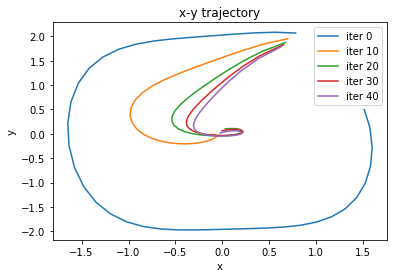

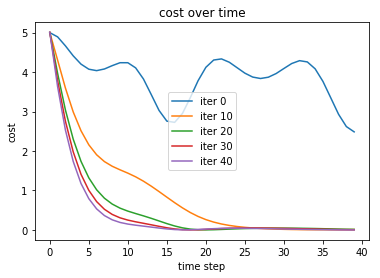

In [8]:
for i, trajectory in enumerate(trajectories[::10]):
    x_pos = []
    y_pos = []
    l_hist = []
    for x, u_t, l, _, _ in trajectory:
        x_pos.append(x[0])
        y_pos.append(x[1])
        l_hist.append(l)
    plt.figure(1)
    plt.plot(x_pos, y_pos, label='iter {}'.format(i*10))
    plt.figure(2)
    plt.plot(l_hist, label='iter {}'.format(i*10))
plt.figure(1)
plt.xlabel('x')
plt.ylabel('y')
plt.title('x-y trajectory')
plt.legend()
plt.figure(2)
plt.xlabel('time step')
plt.ylabel('cost')
plt.title('cost over time')
plt.legend()
plt.show()

We can see that each step works towards improving the cost function and completing the task. You can use this formation for almost any problem so long as it is not an impossible task and the system has continuous derivatives. Many of the most common optimal controllers and trajectory planners (like iLQR) work in similar ways where the focus is on improving the gradients for guaranteed convergence and improved speed ups.

Let's try using a different dynamical system with a different task. Here, we will use the planar quadrotor with the task of doing a backflip. The dynamics of the planar quadrotor are given by
$$
    \frac{d}{dt}\begin{bmatrix} x \\ y \\ \theta \\ \dot{x} \\ \dot{y} \\ \dot{\theta}\end{bmatrix} 
    = \begin{bmatrix} \dot{x} \\ \dot{y} \\ \dot{\theta} \\ u_1 \sin (\theta) \\ u_1 \cos (\theta) -g \\ u_2\end{bmatrix}
$$
where $g$ is gravity.

The objective function is then defined as 
$$
    \ell(x,u) = 0.001 u^\top u \qquad m(x) = (\vec{x} - \vec{x}_d)^\top Q (\vec{x} - \vec{x}_d)^\top
$$
where $\vec{x} = \left[ x, y, \theta, \dot{x}, \dot{y}, \dot{\theta} \right]^\top$, $\vec{x}_d = \left[ 8, 0 2 \pi, 0, 0, 0 \right]^\top$, and  $Q = \text{diag}\left( 1, 1, 20, 0.1, 0.1, 20\right)$. Below we write this out in the same way we wrote the model and the objective in the first example.

In [9]:
class PlanarRotor(object):
    def __init__(self):
        self.num_actions = 2
        self.num_states = 6
        self.df = jacfwd(self.f)
    def reset(self):
        return np.array([0., 0., 0., 0., 0., 0.])
    def f(self, inputs):
        x = inputs['x']
        u = inputs['u']
        return np.array([x[3], x[4], x[5],
                        u[0]* np.sin(x[2]),
                        u[0]* np.cos(x[2]) - 9.81,
                        u[1]])

class BackFlipObjective(object):
    def __init__(self):
        self.dl = grad(self.l)
        self.dm = grad(self.m)
        self.target_state = np.array([8., 0., 2.0 * np.pi, 0., 0., 0.])
        self.weights = np.array([1.0, 1.0, 20., 0.1, 0.1, 20.])
    def m(self, x):
        delta_x = x - self.target_state
        return np.sum(np.square(delta_x)*self.weights)
    def l(self, inputs):
        u = inputs['u']
        return 0.001 * np.dot(u, u)

We reinitialize the environment and updated the parameters and the initial seed $u(t)$. You should play with these parameters to see their effect on the resulting control signal and the state. 

In [10]:
env = Env(PlanarRotor(), BackFlipObjective())

# some parameters 
max_iter  = 60
tf        = 40
threshold = 0.01
step_size = 4e-4

# initialize the control with a random sequence of actions
u = [np.array([20.0, .2]) for t in range(tf)]

## some containers
trajectories = []
cost_hist = []

In [11]:
prev_cost = np.inf # initialize the previous cost
for k in range(max_iter): # loop through each iteration
    
    # Forward pass with initial u(t)
    trajectory, cost = forward_pass(env, u)
    
    # save data for later visualization
    trajectories.append(trajectory)
    # calculate the terminal cost
    x, u_t, l, dl, df = trajectory[-1]
    cost += env.objective.m(x)
        
    if k % 10 == 0: # print every 10 steps
        print('iter ', k, ' cost ', cost, step_size)
    if np.abs(prev_cost - cost) < threshold: ## break when done
        break
    if prev_cost < cost: ## if the step size is too large, auto reduce
        step_size *= 0.2
    # define the previous cost
    prev_cost = cost
    
    # compute the terminal condition for the adjoint
    rho = env.objective.dm(x)
    # compute the backward pass to update the control u(t)
    u = backward_pass(env, trajectory, rho)

# last iteration
print('iter ', k, ' cost ', cost, step_size)

iter  0  cost  6100.7124 0.0004
iter  10  cost  220.72415 0.0004
iter  20  cost  79.392845 0.0004
iter  30  cost  47.422253 0.0004
iter  40  cost  33.00518 0.0004
iter  50  cost  24.072237 0.0004
iter  59  cost  18.556602 0.0004


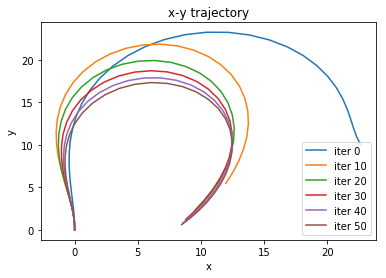

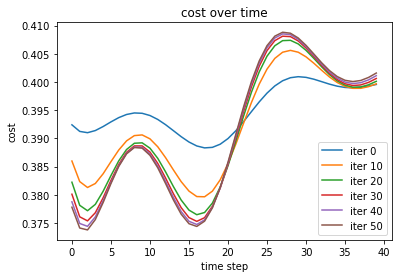

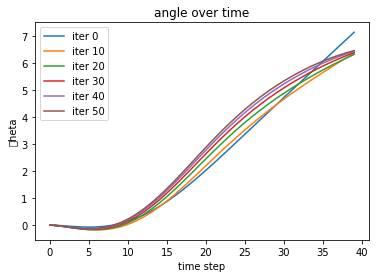

In [12]:
for i, trajectory in enumerate(trajectories[5::10]):
    x_pos = []
    y_pos = []
    theta = []
    l_hist = []
    for x, u_t, l, _, _ in trajectory:
        x_pos.append(x[0])
        y_pos.append(x[1])
        theta.append(x[2])
        l_hist.append(l)
    plt.figure(1)
    plt.plot(x_pos, y_pos, label='iter {}'.format(i*10))
    plt.figure(2)
    plt.plot(l_hist, label='iter {}'.format(i*10))
    plt.figure(3)
    plt.plot(theta, label='iter {}'.format(i*10))
plt.figure(1)
plt.xlabel('x')
plt.ylabel('y')
plt.title('x-y trajectory')
plt.legend()
plt.figure(2)
plt.xlabel('time step')
plt.ylabel('cost')
plt.title('cost over time')
plt.legend()

plt.figure(3)
plt.xlabel('time step')
plt.ylabel('\theta')
plt.title('angle over time')
plt.legend()
plt.show()